# Autoencoders for Dogs and Cats Deep Fake Dataset


Paper reference:

https://www.researchgate.net/publication/349703826_Deepfakes_generation_and_detection_state-of-the-art_open_challenges_countermeasures_and_way_forward

Code Reference:
https://www.codeproject.com/Articles/5298025/Building-and-Training-Deep-Fake-Autoencoders

Library Import

In [ ]:
import numpy as np
import pandas as pd
import zipfile
import cv2
import shutil
import zipfile
import os
import zipfile
import gc
import copy
import math
import warnings
import random
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import albumentations as A
import torchvision
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
import torch.utils.data as data_utils
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import PIL
import torch.utils.data as data_utils
import xml.etree.ElementTree as ET # Parse XML Data.

from PIL import Image
from torch.utils.data import Dataset
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.python.client import device_lib
from zipfile import ZipFile
from IPython import display
from torchvision import models, transforms
from google.colab.patches import cv2_imshow
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.preprocessing import LabelEncoder

In [ ]:
print("Device Specifications:")
print(device_lib.list_local_devices())

Device Specifications:
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17122381086556408406
xla_global_id: -1
]


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Data Preparation

In [ ]:
! cp ./drive/MyDrive/Kaggle/kaggle.json ~/.kaggle/
! kaggle datasets download -d andrewmvd/animal-faces
! unzip ./animal-faces.zip

Streaming output truncated to the last 5000 lines.
  inflating: afhq/train/wild/flickr_wild_001378.jpg  
  inflating: afhq/train/wild/flickr_wild_001379.jpg  
  inflating: afhq/train/wild/flickr_wild_001380.jpg  
  inflating: afhq/train/wild/flickr_wild_001381.jpg  
  inflating: afhq/train/wild/flickr_wild_001382.jpg  
  inflating: afhq/train/wild/flickr_wild_001384.jpg  
  inflating: afhq/train/wild/flickr_wild_001385.jpg  
  inflating: afhq/train/wild/flickr_wild_001386.jpg  
  inflating: afhq/train/wild/flickr_wild_001387.jpg  
  inflating: afhq/train/wild/flickr_wild_001388.jpg  
  inflating: afhq/train/wild/flickr_wild_001389.jpg  
  inflating: afhq/train/wild/flickr_wild_001390.jpg  
  inflating: afhq/train/wild/flickr_wild_001391.jpg  
  inflating: afhq/train/wild/flickr_wild_001392.jpg  
  inflating: afhq/train/wild/flickr_wild_001393.jpg  
  inflating: afhq/train/wild/flickr_wild_001394.jpg  
  inflating: afhq/train/wild/flickr_wild_001395.jpg  
  inflating: afhq/train/wild/fl

## Data Preprocessing

Load Pytorch Dataset based on each folders.

In [ ]:
animal_train_image_folders = torchvision.datasets.ImageFolder(
  "./afhq/train/",
)

animal_val_image_folders = torchvision.datasets.ImageFolder(
  "./afhq/val/",
)

print(animal_train_image_folders)
print(animal_val_image_folders)

Dataset ImageFolder
    Number of datapoints: 14630
    Root location: ./afhq/train/
Dataset ImageFolder
    Number of datapoints: 1500
    Root location: ./afhq/val/


In [ ]:
image_transforms = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.ToTensor(),
    # transforms.Normalize((0.5, ), (0.5, ))
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                      std=[0.229, 0.224, 0.225])
])

class AnimalFaceDataset(Dataset):
  def __init__(self, image_folder_dataset, filter_indexes, image_transforms):
    super(AnimalFaceDataset, self).__init__()

    # DEFINE GLOBAL VARIABLES TO HELP UNDERSTANDING THE CODE
    self.FILE_PATH = 0
    self.CLASS_INDEX = 1

    self.image_folder_dataset = list(filter(lambda x: x[self.CLASS_INDEX] in filter_indexes, image_folder_dataset.imgs))
    self.image_transforms = image_transforms

  def horizontal_flip_image(self, image): 
    return TF.hflip(image)

  def rotate_image(self, image, angle):
    return TF.rotate(image, angle)

  def __getitem__(self, index):
    image_folder = self.image_folder_dataset[index]
    image = Image.open(image_folder[self.FILE_PATH])

    if self.image_transforms:
      image = self.image_transforms(image)


    # # Apply Augmentations to avoid overfitting.
    # random_angle_of_rotation = random.uniform(-20, 20)
    # # random_color_jitter = random.uniform(-0.5, 0.5)
    # is_hflip = random.randint(0, 1)

    # input_image = image
    # output_image = image

    # # input_image = self.change_hue(input_image, random_color_jitter)
    # # output_image = self.change_hue(output_image, random_color_jitter)

    # input_image = self.rotate_image(input_image, random_angle_of_rotation)
    # output_image = self.rotate_image(output_image, random_angle_of_rotation)

    # if is_hflip:
    #   input_image = self.horizontal_flip_image(input_image)
    #   output_image = self.horizontal_flip_image(output_image)

    # input_image = self.additional_image_transform(input_image)
    # output_image = self.additional_image_transform(output_image)

    return image, image

  def __len__(self):
    return len(self.image_folder_dataset)

CAT_CLASS = 0
DOG_CLASS = 1
WILD_CLASS = 2

dog_faces_train_dataset = AnimalFaceDataset(
    image_folder_dataset = animal_train_image_folders,
    filter_indexes = [DOG_CLASS],
    image_transforms = image_transforms,
)
dog_faces_val_dataset = AnimalFaceDataset(
    image_folder_dataset = animal_val_image_folders,
    filter_indexes = [DOG_CLASS],
    image_transforms = image_transforms,
)
cat_faces_train_dataset = AnimalFaceDataset(
    image_folder_dataset = animal_train_image_folders,
    filter_indexes = [CAT_CLASS],
    image_transforms = image_transforms,
)
cat_faces_val_dataset = AnimalFaceDataset(
    image_folder_dataset = animal_val_image_folders,
    filter_indexes = [CAT_CLASS],
    image_transforms = image_transforms,
)

print("Length of Dogs Train Dataset")
print(len(dog_faces_train_dataset))
print(len(dog_faces_val_dataset))

print("Length of Cats Train Dataset")
print(len(cat_faces_train_dataset))
print(len(cat_faces_val_dataset))

Length of Dogs Train Dataset
4739
500
Length of Cats Train Dataset
5153
500


In [ ]:
BATCH_SIZE = 16

dog_train_loader = torch.utils.data.DataLoader(
    dog_faces_train_dataset,
    batch_size = BATCH_SIZE,
)

dog_val_loader = torch.utils.data.DataLoader(
    dog_faces_val_dataset,
    batch_size = BATCH_SIZE,
)

cat_train_loader = torch.utils.data.DataLoader(
    cat_faces_train_dataset,
    batch_size = BATCH_SIZE,
)

cat_val_loader = torch.utils.data.DataLoader(
    cat_faces_val_dataset,
    batch_size = BATCH_SIZE,
)

Visualize Some Images after Transformation.

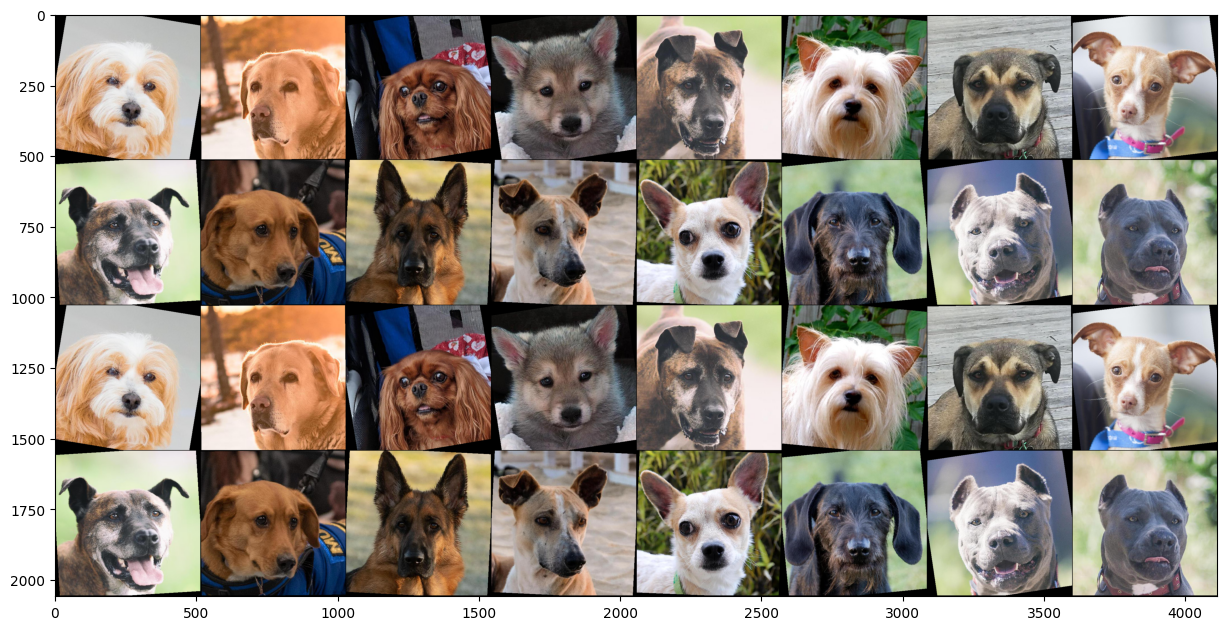

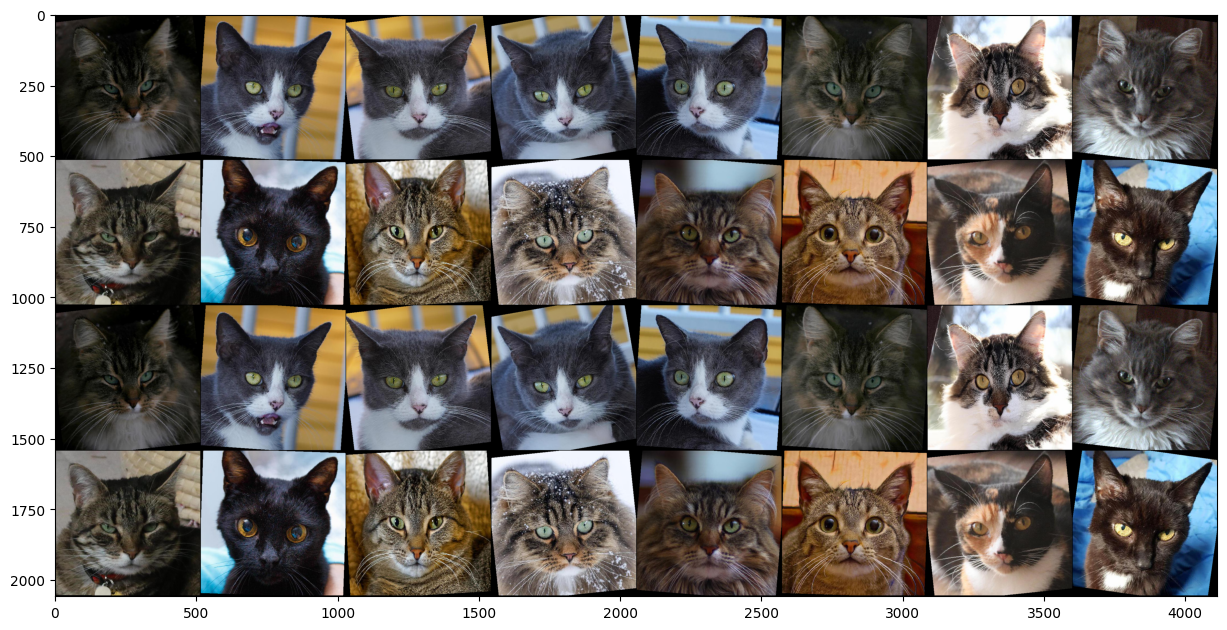

In [ ]:
def plot_images_in_grid(title, images, labels, figsize = (15, 15), MIN_INDEX_PLOT = 0, MAX_INDEX_PLOT = 20):
  plt.figure(figsize = figsize)
  plt.suptitle(title)
  for index in range(MIN_INDEX_PLOT, MAX_INDEX_PLOT):
    plt.subplot(5, 5, index + 1)
    plt.axis('off')
    plt.text(x = 10, y = 0.5, s = labels[index], fontsize = 10, bbox = dict(facecolor = 'white'))
    plt.imshow(images[index], cmap = 'gray')

def visualize_pytorch_grid(images_in_batch):
  plt.figure(figsize = (15, 15))
  grid_images_in_batch = torchvision.utils.make_grid(images_in_batch)
  plt_compatible_grid_images_in_batch = np.transpose(grid_images_in_batch.numpy(), (1, 2, 0))
  plt.imshow(plt_compatible_grid_images_in_batch)

def visualize_dataloader(data_loader, title):
  iter_loader = iter(data_loader)
  input_image, output_image = next(iter_loader)

  sample_image_batch = torch.cat(
      [input_image,  output_image], 
      0,
  )

  visualize_pytorch_grid(sample_image_batch)

MIN_INDEX_PLOT = 1
MAX_INDEX_PLOT = 20

visualize_dataloader(dog_train_loader, "Dogs Transformed Image")
visualize_dataloader(cat_train_loader, "Cats Transformed Image")

## Data Modelling

In [ ]:
class AnimalEncoderModel(nn.Module):
  def __init__(self):
    super(AnimalEncoderModel, self).__init__()
    # 224
    self.encoder_1 = nn.Sequential(
      nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, padding = 1), 
      nn.MaxPool2d(2, 2),
      nn.ReLU(),
    )
    # 112
    self.encoder_2 = nn.Sequential(
      nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1), 
      nn.MaxPool2d(2, 2),
      nn.ReLU(),
    )
    # 56
    self.encoder_3 = nn.Sequential(
      nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, padding = 1), 
      nn.MaxPool2d(2, 2),
      nn.ReLU(),
    )
    # self.encoder_4 = nn.Sequential(
    #   nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, padding = 1), 
    #   nn.MaxPool2d(2, 2),
    #   nn.ReLU(),
    # )

  def forward(self, x):
    x = self.encoder_1(x)
    x = self.encoder_2(x)
    x = self.encoder_3(x)
    # x = self.encoder_4(x)
    return x

class AnimalDecoderModel(nn.Module):
  def __init__(self):
    super(AnimalDecoderModel, self).__init__()
    # self.decoder_1 = nn.Sequential(
    #     nn.ReLU(),
    #     nn.Upsample(scale_factor = 2), 
    #     nn.Conv2d(in_channels = 256, out_channels = 128, kernel_size = 3, padding = 1),
    # )
    self.decoder_2 = nn.Sequential(
        nn.ReLU(),
        nn.Upsample(scale_factor = 2), 
        nn.Conv2d(in_channels = 128, out_channels = 64, kernel_size = 3, padding = 1), 
    )
    self.decoder_3 = nn.Sequential(
        nn.ReLU(),
        nn.Upsample(scale_factor = 2), 
        nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 3, padding = 1),
    )
    self.decoder_4 = nn.Sequential(
        nn.ReLU(),
        nn.Upsample(scale_factor = 2), 
        nn.Conv2d(in_channels = 32, out_channels = 3, kernel_size = 3, padding = 1),
    )

  def forward(self, x):
    # x = self.decoder_1(x)
    x = self.decoder_2(x)
    x = self.decoder_3(x)
    x = self.decoder_4(x)
    return x

print(AnimalEncoderModel())
print(AnimalDecoderModel())

AnimalEncoderModel(
  (encoder_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (encoder_2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (encoder_3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
)
AnimalDecoderModel(
  (decoder_2): Sequential(
    (0): ReLU()
    (1): Upsample(scale_factor=2.0, mode=nearest)
    (2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (decoder_3): Sequential(
    (0): ReLU()
    (1): Upsample(scale_factor=2.0, mode=nearest)
    (2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [ ]:
class AnimalAutoencoders(nn.Module):
  def __init__(self, encoder):
    super(AnimalAutoencoders, self).__init__()
    self.encoder = encoder

  def replace_decoder(self, decoder):
    self.decoder = decoder
    return self
  
  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x  

In [ ]:
encoder = AnimalEncoderModel().to(device)

# cat_encoder = copy.deepcopy(dog_encoder)

dog_decoder = AnimalDecoderModel().to(device)
cat_decoder = AnimalDecoderModel().to(device)

dog_autoencoder = AnimalAutoencoders(encoder).replace_decoder(dog_decoder).to(device)

dog_optimizer = optim.Adam(dog_autoencoder.parameters(), lr = 0.00001)

loss = nn.MSELoss()

epochs = 1

def validate_autoencoder(autoencoder, val_data_loader, loss_func, current_epoch, verbose = True):
  with torch.no_grad():
    correct = 0
    total = 0
    # total_validation_losses = 0
    total_val_iterations = 1
    for val_iteration, (input_image, output_image) in enumerate(val_data_loader):
      
      input_image = input_image.to(device)
      output_image = output_image.to(device)

      predicted_image = autoencoder(input_image)
      val_loss = loss_func(predicted_image, input_image)
  
      if verbose and val_iteration % 10 == 0 and val_iteration != 0:
        print(f"(Validation) Epochs {current_epoch + 1}, Iteration number: {val_iteration + 1}, Loss: {val_loss.item()}")

      total_val_iterations += 1
      # total_validation_losses += val_loss

def train_autoencoder(autoencoder, train_data_loader, val_data_loader, loss_func, optimizer, epochs = 100, verbose = True):
  for epoch in range(epochs):
    for train_iteration, (input_image, output_image) in enumerate(train_data_loader):
      optimizer.zero_grad()

      input_image = input_image.to(device)
      output_image = output_image.to(device)

      prediction_image = autoencoder(input_image)
      
      current_loss = loss_func(prediction_image, output_image)

      current_loss.backward()
      optimizer.step()

      if verbose and train_iteration % 100 == 0:
        print(f"(Training) Epochs {epoch + 1} / {epochs}, Iteration number: {train_iteration + 1}, loss: {current_loss.item()}")

    validate_autoencoder(autoencoder, val_data_loader, loss_func, epoch,)

train_autoencoder(
  dog_autoencoder, 
  dog_train_loader, 
  dog_val_loader, 
  loss, 
  dog_optimizer,
  epochs
)

cat_autoencoder = AnimalAutoencoders(encoder).replace_decoder(cat_decoder).to(device)
cat_optimizer = optim.Adam(cat_autoencoder.parameters(), lr = 0.00001)

train_autoencoder(
  cat_autoencoder, 
  cat_train_loader, 
  cat_val_loader, 
  loss, 
  cat_optimizer,
  epochs
)

In [ ]:
def compare_models(model_1, model_2):
  # Function to ensure that the models do have the same weights.
    models_differ = 0
    for key_item_1, key_item_2 in zip(model_1.state_dict().items(), model_2.state_dict().items()):
      if torch.equal(key_item_1[1], key_item_2[1]):
          pass
      else:
          models_differ += 1
          if (key_item_1[0] == key_item_2[0]):
              print('Mismtach found at', key_item_1[0])
          else:
              raise Exception
    if models_differ == 0:
        print('Models match perfectly! :)')
        
compare_models(dog_autoencoder, cat_autoencoder)

In [ ]:
SAMPLE_IMAGE_INDEX_1 = 0
SAMPLE_IMAGE_INDEX_2 = 1

for sample_image_index, (sample_image, sample_label) in enumerate(dog_val_loader):
  if sample_image_index == SAMPLE_IMAGE_INDEX_1:
    sample_image_dog = sample_image.to(device)
    break

for sample_image_index, (sample_image, sample_label) in enumerate(cat_val_loader):
  if sample_image_index == SAMPLE_IMAGE_INDEX_2:
    sample_image_cat = sample_image.to(device)
    break

# print(sample_image_1.shape)
# print(sample_image_2.shape)

sample_image_batch = torch.cat(
    [sample_image_dog,  sample_image_cat], 
    0,
)

visualize_pytorch_grid(sample_image_batch.cpu())

In [ ]:
with torch.no_grad():
  decoded_image_dog = dog_autoencoder.encoder(sample_image_dog)
  decoded_image_cat = cat_autoencoder.encoder(sample_image_cat)

  decoded_image_cat = dog_autoencoder.decoder(decoded_image_cat)
  decoded_image_dog = cat_autoencoder.decoder(decoded_image_dog)

  sample_image_batch = torch.cat(
    [decoded_image_dog,  decoded_image_cat], 
    0,
  )
  
  visualize_pytorch_grid(sample_image_batch.cpu())